# Quick Strategy Backtest

In [1]:
qb = QuantBook()
from QuantConnect.Data.Custom.TradingEconomics import *
from QuantConnect.Data.Custom.CBOE import *

s = "EURUSD"
tickersForex  = [
s
]
tickersCfd = []

tickersCBOE = [
    "VIX"
]

symbols = {}
symbolsq = {}
tickers = tickersForex + tickersCfd

resolution = Resolution.Daily
period = 360 * 5

for ticker in tickersCBOE:
    symbolsq[ticker] =  qb.AddData(CBOE, ticker).Symbol 
    
for ticker in tickersCfd:
    symbols[ticker] =  qb.AddCfd(ticker, resolution, Market.Oanda).Symbol

for ticker in tickersForex:
    symbols[ticker] =  qb.AddForex(ticker, resolution, Market.Oanda).Symbol


# Reihen mit Null Werten werden gelöscht    
df = None
symbolsList = []
for key in symbols:
    symbolsList.append(key)
df = qb.History(symbolsList, 
                     period, 
                     resolution).close.unstack(level=0).dropna()

dfq  = None


symbolsListq = []
for key in symbolsq:
    symbolsListq.append(key)
dfq = qb.History(symbolsListq, 
                     period, 
                     resolution).close.unstack(level=0).dropna()


df['emaSlow'] = qb.Indicator(ExponentialMovingAverage(100), s, period, resolution)
df['emaFast'] = qb.Indicator(ExponentialMovingAverage(20), s, period, resolution)

dfq = dfq.rename(lambda x: x.replace(minute=0))
df = df.rename(lambda x: x.replace(minute=0, hour=0))
df = pd.concat([dfq, df], axis=1).dropna()






/opt/miniconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Profit / Loss (abs): 8261.0
Profit / Loss (%): 275%
Profit / Loss per Trade: 590.07
Number of Trades: 14
Winners: 6
Loosers: 8
Profit per win trade: 3272.83
Loss per loose trade: -1422.0


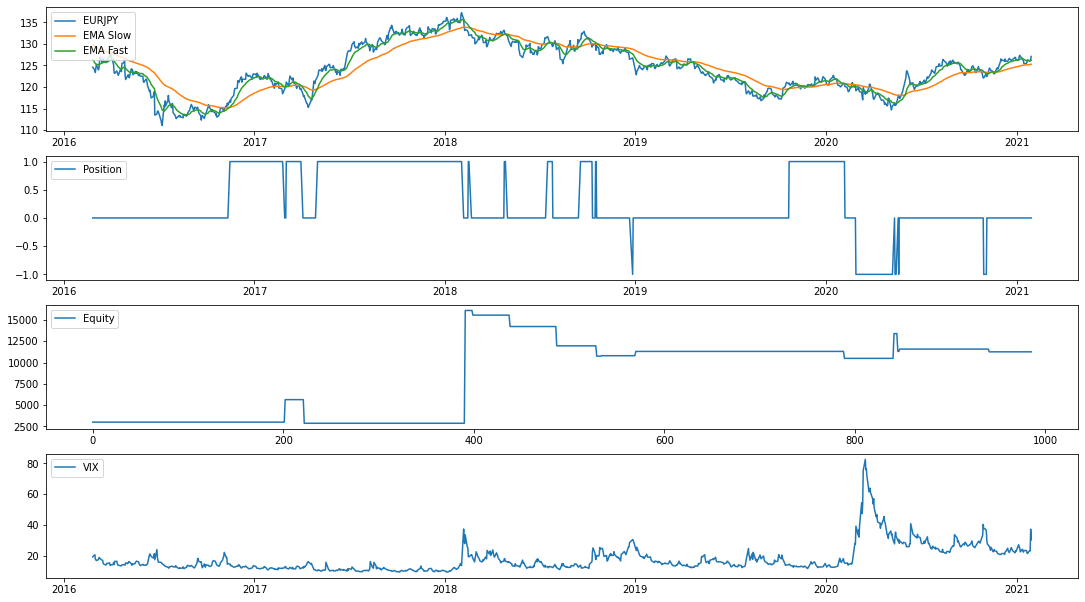

In [2]:


symbol = s

df['position'] = 0
df['diff'] = df['emaFast'] > df['emaSlow']


def emaInsight(i):
    if ((i['emaFast'] > i['emaSlow']) and i['VIX.CBOE 2S'] < 20):
        return 1
    if ((i['emaFast'] < i['emaSlow']) and i['VIX.CBOE 2S'] > 30):
        return -1
    return 0

df['position'] = df.apply(lambda row: emaInsight(row), axis=1)


capital =  3000
size = 1000

open = None
direction = 0
equityCurve = []
equity = capital
numberOfTrades  = 0
winTrades = 0
looseTrades = 0
winSum = 0
looseSum  = 0
pl = 0

for index, row in df.iterrows():
   
    equityCurve.append(equity)
    positionChange = False
    
    if row.position == 1 and direction == 0:
        # switch to long position
        if open:
            result = (row[s] - open) * size
            positionChange = True
        open = row[symbol]
        direction = 1
        

        
    if row.position == -1 and direction == 0:
        # switch to short position
        if open:
            result = (open - row[symbol]) * size
            positionChange = True
        open = row[symbol]
        direction = -1
        
    if row.position == 0 and direction == 1:
        direction = 0
        if open:
            result = (row[symbol] - open) * size
        positionChange = True
        open = None
        
    if row.position == 0 and direction == -1:
        direction = 0
        if open:
            result = (open - row[symbol]) * size
        positionChange = True
        open = None
        
    if positionChange:
        numberOfTrades += 1
        equity += result
        pl += result
        if result >= 0:
            winTrades += 1
            winSum +=  result
        else:
            looseTrades += 1
            looseSum += result
        
dfe = pd.DataFrame(equityCurve)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(4) 
fig.set_size_inches(18.5, 10.5)

axs[0].plot(df[symbol], label=symbol) 
axs[0].plot(df['emaSlow'], label='EMA Slow') 
axs[0].plot(df['emaFast'], label='EMA Fast') 
axs[0].legend(loc="upper left")

axs[1].plot(df['position'], label="Position")
axs[1].legend(loc="upper left")

axs[2].plot(dfe, label="Equity")
axs[2].legend(loc="upper left")

axs[3].plot(df['VIX.CBOE 2S'], label="VIX")
axs[3].legend(loc="upper left")

plPercent = round((equity / capital * 100) - 100)
profitPerWinTrade = 0
lossPerLooseTrade = 0

if winTrades > 0:
    profitPerWinTrade = round(winSum / winTrades, 2)
    
if looseTrades > 0:
    lossPerLooseTrade = round(looseSum / looseTrades, 2)
    
plPerTrade = 0
if numberOfTrades > 0:
    plPerTrade = round(pl / numberOfTrades, 2)
    
print("Profit / Loss (abs): " + str(round(pl, 2)))
print("Profit / Loss (%): " + str(plPercent) + "%")
print("Profit / Loss per Trade: " + str(plPerTrade))
print("Number of Trades: " + str(numberOfTrades))
print("Winners: " + str(winTrades))
print("Loosers: " + str(looseTrades))
print("Profit per win trade: " + str(profitPerWinTrade))
print("Loss per loose trade: " + str(lossPerLooseTrade))

